In [2]:
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
from num2tex import num2tex

In [3]:
here = Path('../').resolve()
benchmarks = (here ).resolve()
print(benchmarks)
sys.path.append(str(benchmarks))

plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    "figure.figsize": (6,4),
    'figure.dpi':150
})

sns.set_theme()
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

/scratch/ndeutsch/zunis/zunis/experiments/benchmarks


In [4]:
from utils.data_storage.dataframe2sql import read_pkl_sql
from utils.config.loaders import get_sql_types
import sqlite3 as sql
from sqlalchemy import PickleType


In [5]:
con = sql.connect("benchmarks.db")
con.cursor().execute("SELECT name FROM sqlite_master where type = 'table'").fetchall()

[('camel_defaults',)]

In [6]:
dtypes = get_sql_types()
dtypes["value_history"] = PickleType

df = read_pkl_sql("benchmarks.db", "camel_defaults", dtypes=dtypes)
df.columns = df.columns.astype(str)
d_sigmas = pd.read_csv('../../exploration/gaussian_camel_integrands.csv')
d_sigma_camel = d_sigmas[['d','sigma_camel','sigma_1d','relative_std_camel']].rename(columns=
                                                                     {
                                                                         "sigma_camel":'s',
                                                                         'relative_std_camel':'relative_std'
                                                                     })

df = df.merge(d_sigma_camel,on=["d","s"],how="left")

In [7]:
dtypes = get_sql_types()
dtypes["value_history"] = PickleType

df2 = read_pkl_sql("benchmarks.db", "camel_defaults", dtypes=dtypes)
df2.columns = df2.columns.astype(str)
d_sigmas = pd.read_csv('../../exploration/gaussian_camel_integrands.csv')
d_sigma_camel = d_sigmas[['d','sigma_camel','sigma_1d','relative_std_camel']].rename(columns=
                                                                     {
                                                                         "sigma_camel":'s',
                                                                         'relative_std_camel':'relative_std'
                                                                     })

df2 = df2.merge(d_sigma_camel,on=["d","s"],how="left")

In [19]:
df.head()

,value,value_std,value_unweighting_eff,value_history,target_history,flat_target,flat_target_std,flat_sigma_cutoff,flat_sigmas_off,flat_percent_difference,...,s,norm,d,time_zunis,time_vegas,stratified,git_info,extra_data,sigma_1d,relative_std
0,0.002509,0.000002,0.217483,integral error n_points phase \ 0 ...,None,0.002373,0.000108,3.0,1.266011,5.584331,...,0.019974,1.0,2,49.206656,0.274867,False,686c18efbf95a1ed7cda1ef51a0d9a5fe189a8c0:5017a...,(),0.001,14.105713
1,0.002509,0.000002,0.106458,integral error n_points phase \ 0 ...,None,0.002372,0.000109,3.0,1.257039,5.604030,...,0.019974,1.0,2,48.002832,0.279407,False,686c18efbf95a1ed7cda1ef51a0d9a5fe189a8c0:5017a...,(),0.001,14.105713
2,0.001253,0.000002,0.115075,integral error n_points phase \ 0 ...,None,0.001325,0.000059,3.0,1.206634,5.519813,...,0.089272,1.0,4,103.505195,0.388924,False,686c18efbf95a1ed7cda1ef51a0d9a5fe189a8c0:5017a...,(),0.001,14.105713
3,0.002504,0.000005,0.024324,integral error n_points phase \ 0 ...,None,0.002498,0.000112,3.0,0.047393,0.213100,...,0.019974,1.0,2,47.976172,0.202012,False,686c18efbf95a1ed7cda1ef51a0d9a5fe189a8c0:5017a...,(),0.001,14.105713
4,0.002510,0.000004,0.042811,integral error n_points phase \ 0 ...,None,0.002628,0.000116,3.0,1.020160,4.597390,...,0.019974,1.0,2,48.253438,0.077374,False,686c18efbf95a1ed7cda1ef51a0d9a5fe189a8c0:5017a...,(),0.001,14.105713


In [20]:
blip = df.loc[(df['d'] == 32) & (df.relative_std > 14)]['flat_variance_ratio']
print(blip.mean(), blip.quantile(0.32), blip.quantile(0.68))

1.2975858261984976 0.8398427125731951 1.4424663914847669


In [22]:
df[['loss', 'survey_strategy']].value_counts()

loss      survey_strategy  
variance  forward              350
          flat                 350
          adaptive_variance    350
dkl       forward              350
          flat                 350
          adaptive_dkl         350
dtype: int64

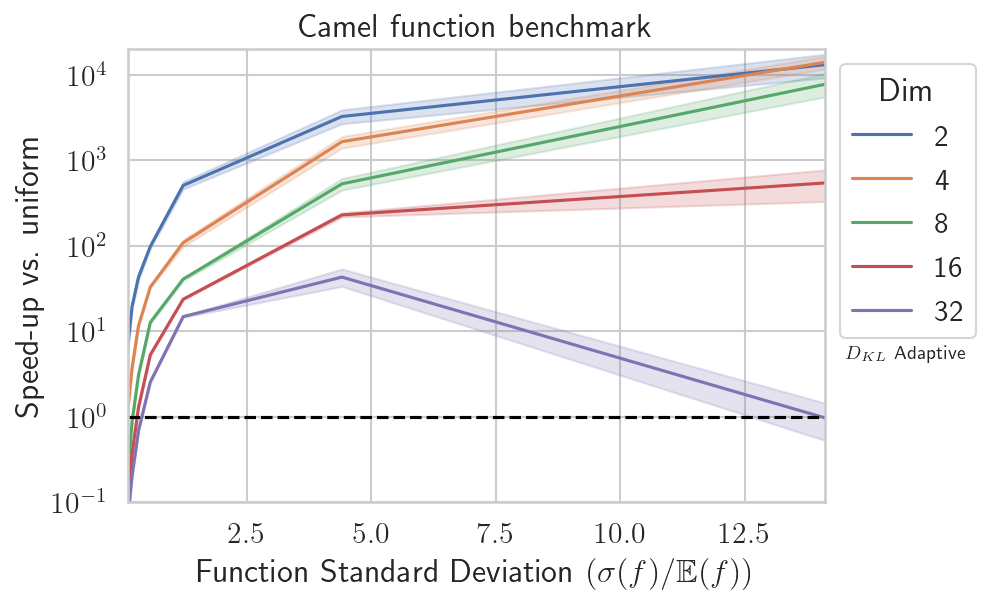

In [54]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'adaptive_dkl']
data = data[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 2e4], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,4.8e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

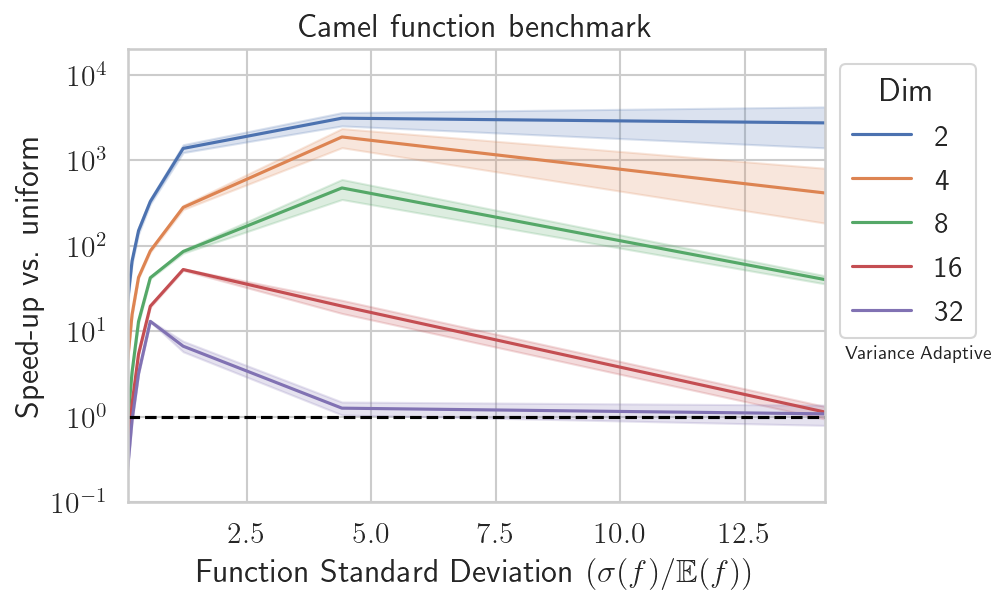

In [55]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'adaptive_variance']
data = data[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 2e4], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,4.8e0,'Variance Adaptive', fontsize='xx-small')
plt.show()

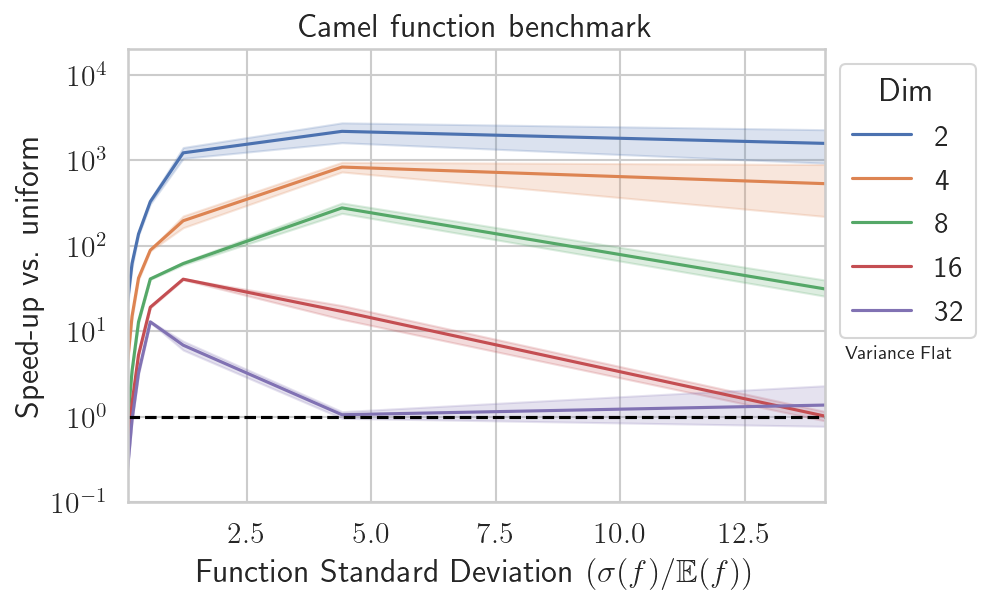

In [59]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'flat'].loc[df.loss=='variance']
data = data[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 2e4], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,4.8e0,'Variance Flat', fontsize='xx-small')
plt.show()

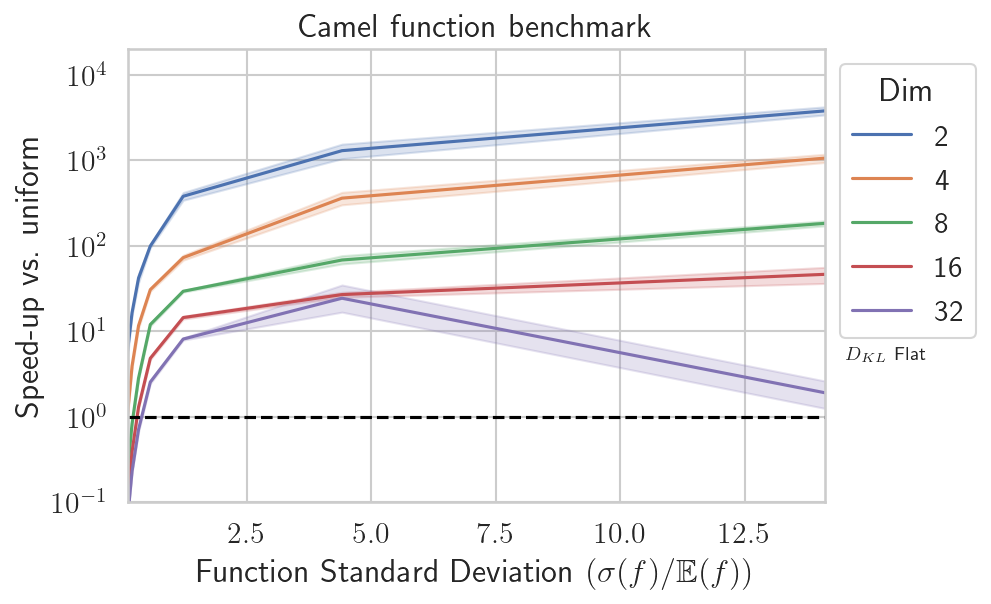

In [60]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'flat'].loc[df.loss=='dkl']
data = data[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 2e4], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,4.8e0,'$D_{KL}$ Flat', fontsize='xx-small')
plt.show()

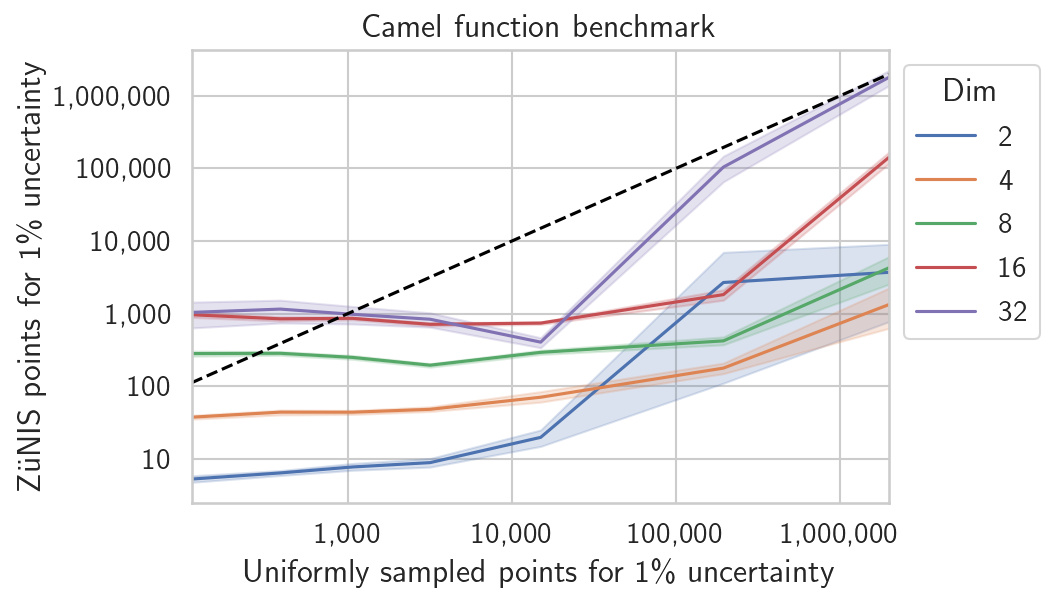

In [10]:
var_param='n_to_percent'
data = df[['flat_variance_ratio']].assign(Dim=df['d'].astype(str), n_to_percent=(df.relative_std*100)**2,
zunis_n_to_percent =  (df.relative_std*100)**2 / df.flat_variance_ratio)
ax = sns.lineplot(data=data,x=var_param,y='zunis_n_to_percent', hue='Dim')
ax.plot([data['n_to_percent'].min(),data['n_to_percent'].max()], [data['n_to_percent'].min(),data['n_to_percent'].max()],c='black',ls='--')
ax.set(yscale='log', xscale='log',xlim=[data['n_to_percent'].min(),data['n_to_percent'].max()])
ax.set(xlabel='Uniformly sampled points for 1\% uncertainty', ylabel='ZüNIS points for 1\% uncertainty')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

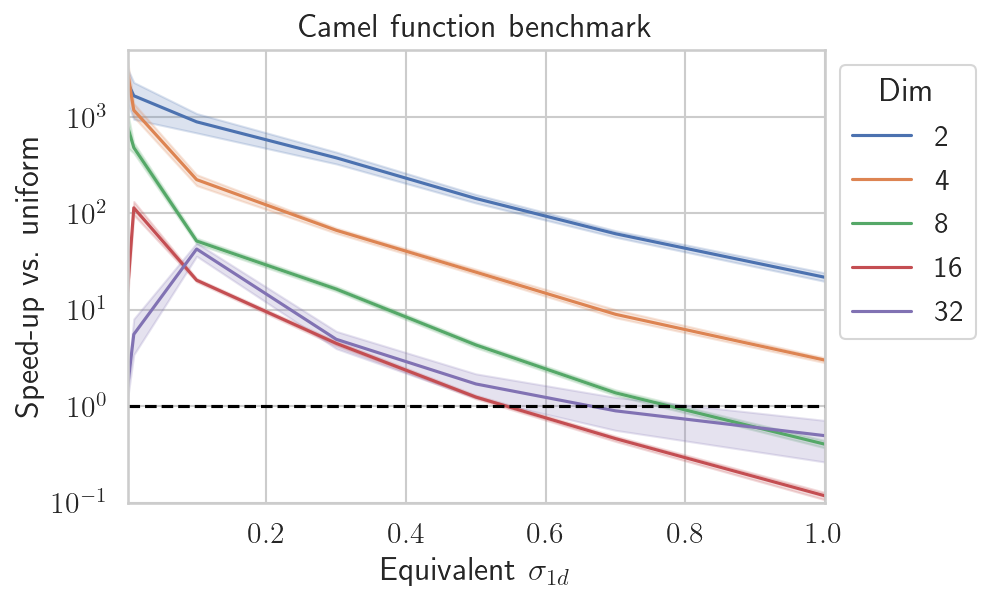

In [11]:
var_param = 'sigma_1d'
data = df[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Equivalent $\sigma_{1d}$', ylabel='Speed-up vs. uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

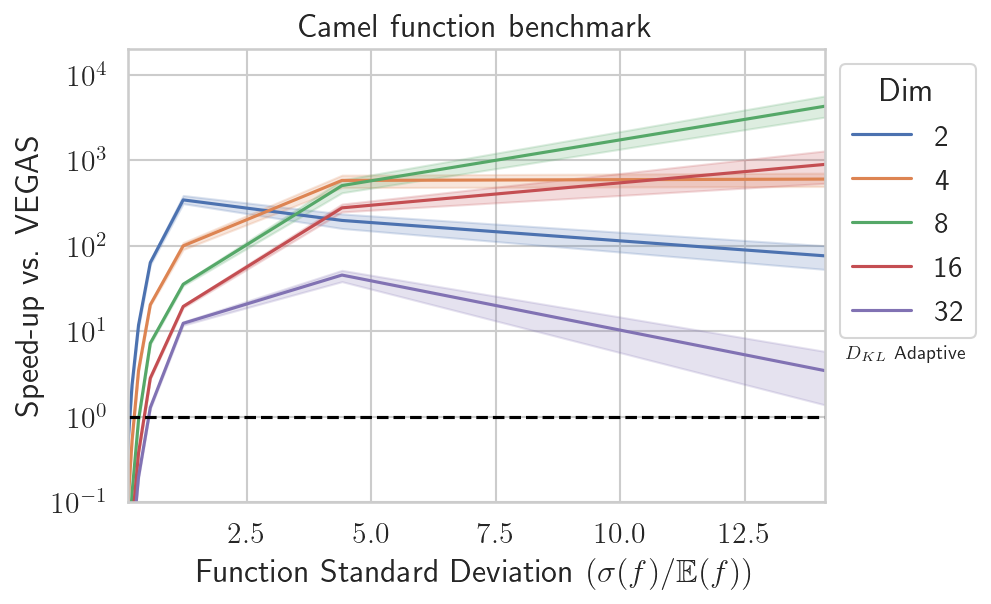

In [62]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'adaptive_dkl']
data = data[[var_param, 'vegas_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 2e4], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,4.8e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

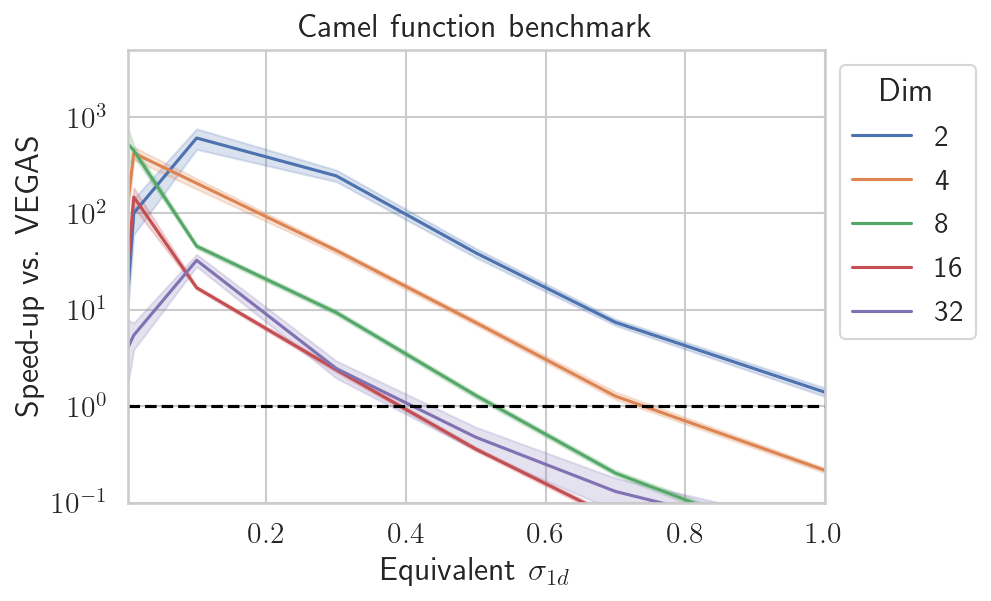

In [13]:
var_param = 'sigma_1d'
data = df[[var_param, 'vegas_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_variance_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, 5000], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Equivalent $\sigma_{1d}$', ylabel='Speed-up vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

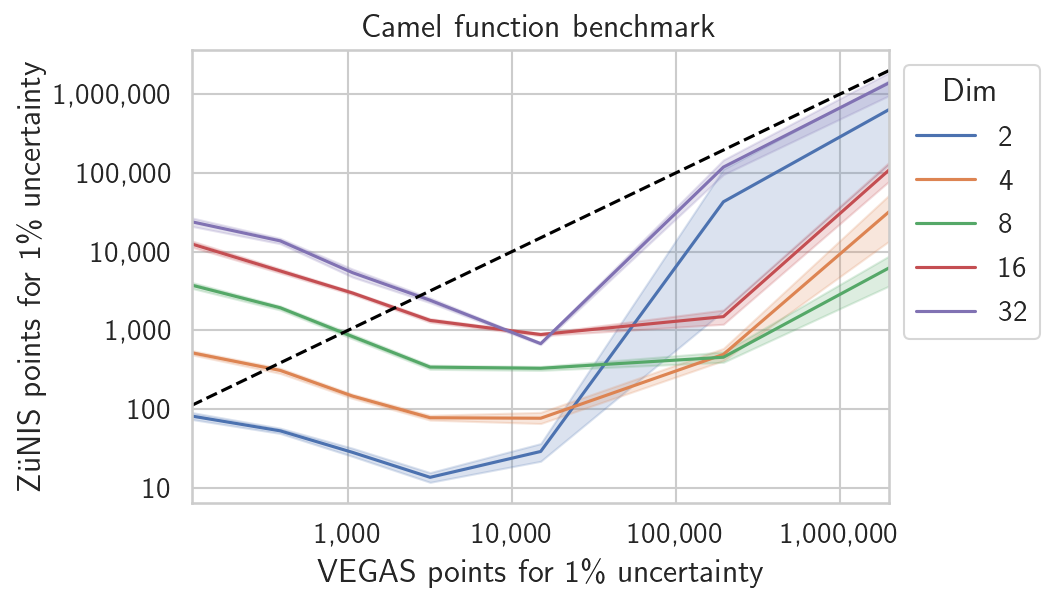

In [14]:
var_param='n_to_percent'
data = df[['vegas_variance_ratio']].assign(Dim=df['d'].astype(str), n_to_percent=(df.relative_std*100)**2,
zunis_n_to_percent =  (df.relative_std*100)**2 / df.vegas_variance_ratio)
ax = sns.lineplot(data=data,x=var_param,y='zunis_n_to_percent', hue='Dim')
ax.plot([data['n_to_percent'].min(),data['n_to_percent'].max()], [data['n_to_percent'].min(),data['n_to_percent'].max()],c='black',ls='--')
ax.set(yscale='log', xscale='log',xlim=[data['n_to_percent'].min(),data['n_to_percent'].max()])
ax.set(xlabel='VEGAS points for 1\% uncertainty', ylabel='ZüNIS points for 1\% uncertainty')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

### Making a table

In [64]:
import scikits.bootstrap as boot

In [123]:
data = df.loc[df.survey_strategy=='adaptive_dkl']
table_vegas = data.groupby(['sigma_1d', 'd'])['vegas_variance_ratio'].agg(['mean',lambda x: tuple(boot.ci(x))])
table_flat = data.groupby(['sigma_1d', 'd'])['flat_variance_ratio'].agg(['mean',lambda x: tuple(boot.ci(x))])

table_std=data[['sigma_1d','d', 'relative_std']].drop_duplicates().set_index(['sigma_1d', 'd'])

table_vegas = table_vegas.join(table_std)
table_flat = table_flat.join(table_std)

In [124]:
table_string = ""
for tab in table_vegas.groupby(level=0):
    sig1d = tab[0]
    std = num2tex(f"{tab[1]['relative_std'].iloc[0]:.2f}")
    for r in tab[1].iterrows():
        row = r[1]
        mean_val, mean_exp = f"{row['mean']:.1e}".split('e')
        mean_exp = str(int(mean_exp))
        pretty_u = f"{(row['<lambda_0>'][1]-row['mean'])/ 10**(int(mean_exp)):.1f}"
        pretty_l = f"{(row['mean']-row['<lambda_0>'][0])/ 10**(int(mean_exp)):.1f}"
        table_string+=f" & ${mean_val}^{{+{pretty_u}}}_{{-{pretty_l}}} \\times 10^{{{mean_exp}}}$"
    table_string+=f" & ${sig1d}$  & ${std}$\\\ \n"
print(table_string)

 & $7.6^{+2.4}_{-2.4} \times 10^{1}$ & $6.0^{+1.2}_{-1.0} \times 10^{2}$ & $4.3^{+1.4}_{-1.0} \times 10^{3}$ & $9.0^{+4.7}_{-3.1} \times 10^{2}$ & $3.5^{+2.7}_{-1.8} \times 10^{0}$ & $0.001$  & $14.11$\\ 
 & $2.0^{+0.4}_{-0.4} \times 10^{2}$ & $5.8^{+0.8}_{-1.0} \times 10^{2}$ & $5.1^{+0.8}_{-0.9} \times 10^{2}$ & $2.8^{+0.3}_{-0.3} \times 10^{2}$ & $4.5^{+0.6}_{-0.8} \times 10^{1}$ & $0.01$  & $4.41$\\ 
 & $3.4^{+0.5}_{-0.3} \times 10^{2}$ & $1.0^{+0.1}_{-0.1} \times 10^{2}$ & $3.5^{+0.1}_{-0.2} \times 10^{1}$ & $1.9^{+0.1}_{-0.1} \times 10^{1}$ & $1.2^{+0.1}_{-0.1} \times 10^{1}$ & $0.1$  & $1.22$\\ 
 & $6.3^{+0.4}_{-0.3} \times 10^{1}$ & $2.0^{+0.0}_{-0.1} \times 10^{1}$ & $7.2^{+0.3}_{-0.3} \times 10^{0}$ & $2.8^{+0.1}_{-0.1} \times 10^{0}$ & $1.3^{+0.1}_{-0.0} \times 10^{0}$ & $0.3$  & $0.56$\\ 
 & $1.2^{+0.1}_{-0.1} \times 10^{1}$ & $3.5^{+0.1}_{-0.2} \times 10^{0}$ & $9.1^{+0.6}_{-0.4} \times 10^{-1}$ & $3.7^{+0.2}_{-0.2} \times 10^{-1}$ & $2.0^{+0.1}_{-0.1} \times 10^{-1}$ & $0

In [18]:
mean_val, mean_exp = f"{row['mean']:.2e}".split('e')
mean_exp = str(int(mean_exp))
pretty_u = f"{(row['<lambda_0>'][1]-row['mean'])/ 10**(int(mean_exp)):.2f}"
pretty_l = f"{(row['mean']-row['<lambda_0>'][0])/ 10**(int(mean_exp)):.2f}"

print(f"${mean_val}^{{+{pretty_u}}}_{{-{pretty_l}}} \\times 10^{{{mean_exp}}}$")

$4.86^{+0.81}_{-0.56} \times 10^{-3}$


# ROI

In [19]:
df_roi =  df.assign(roi_vegas = (df.vegas_variance_ratio) * (df.time_vegas / df.time_zunis))

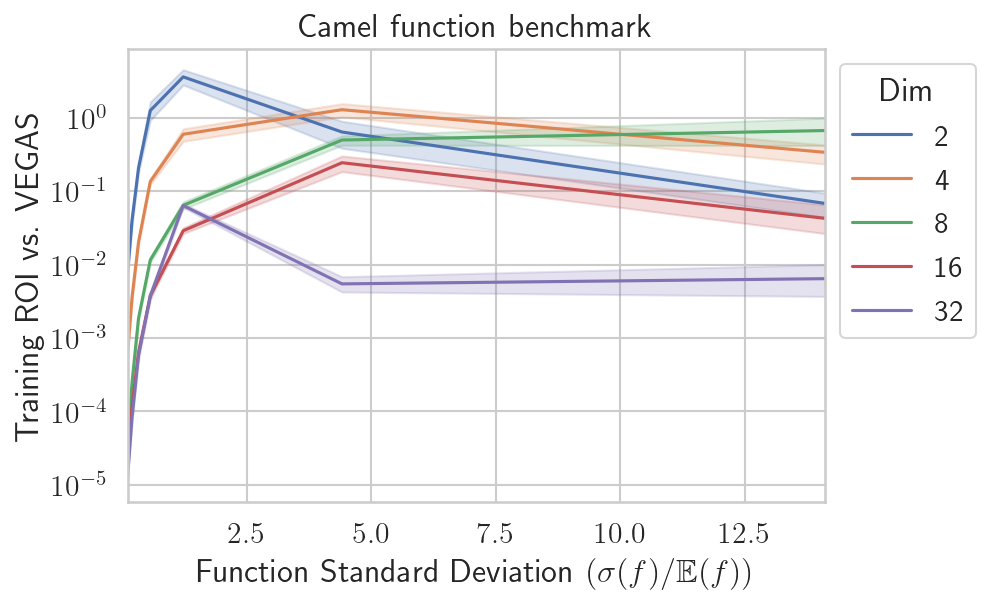

In [20]:
var_param = 'relative_std'
data = df_roi[[var_param, 'roi_vegas']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='roi_vegas', hue='Dim')
ax.set(yscale='log', xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Training ROI vs. VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
plt.show()

# Comparing survey sampling/losses

## Flat vs forward vs adaptive

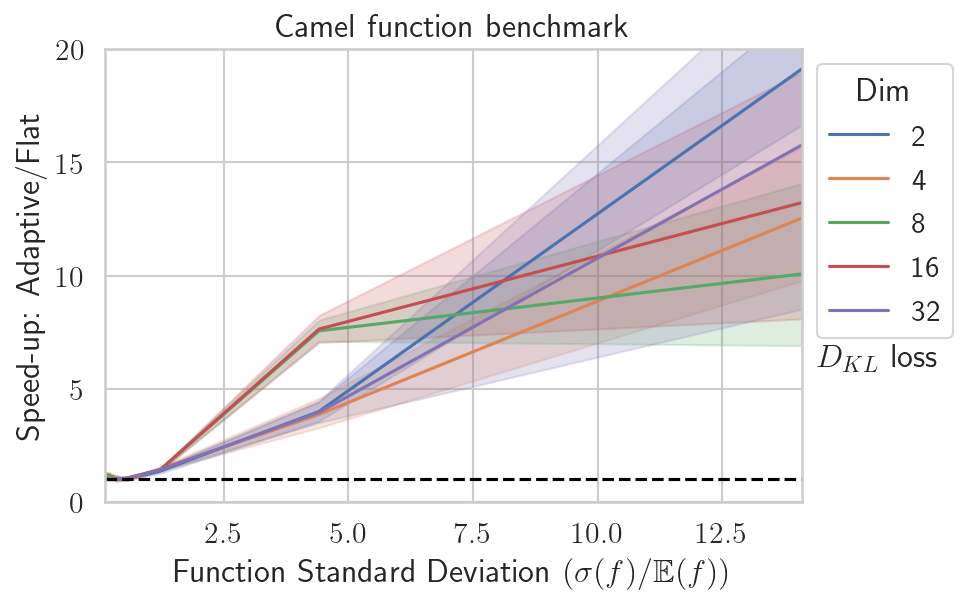

In [93]:
data_flat = df.loc[df.loss=='dkl'].loc[df.survey_strategy=='flat']
data_ada = df.loc[df.loss=='dkl'].loc[df.survey_strategy=='adaptive_dkl']

data = data_flat.merge(data_ada, on='s')
data = data.assign(
    flat_variance_ratio=data.flat_variance_ratio_y/data.flat_variance_ratio_x,
    relative_std = data.relative_std_x
)

data = data[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')


ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(ylim=[0, 2e1], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up: Adaptive/Flat')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.4,6,'$D_{KL}$ loss')
plt.show()

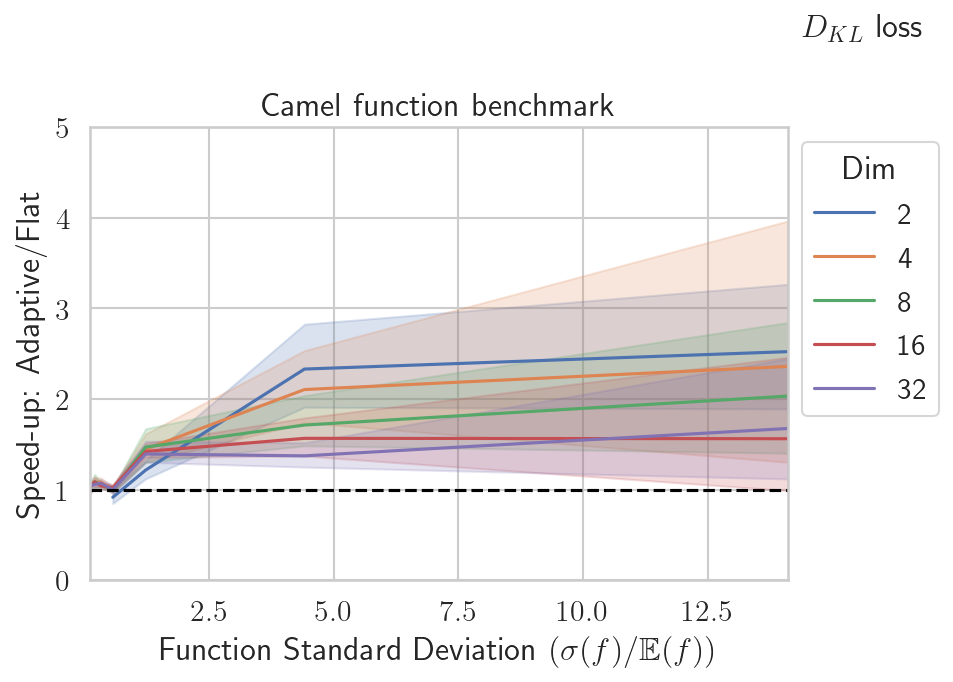

In [95]:
data_flat = df.loc[df.loss=='variance'].loc[df.survey_strategy=='flat']
data_ada = df.loc[df.loss=='variance'].loc[df.survey_strategy=='adaptive_variance']

data = data_flat.merge(data_ada, on='s')
data = data.assign(
    flat_variance_ratio=data.flat_variance_ratio_y/data.flat_variance_ratio_x,
    relative_std = data.relative_std_x
)

data = data[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')


ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(ylim=[0, 5], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up: Adaptive/Flat')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.4,6,'$D_{KL}$ loss')
plt.show()

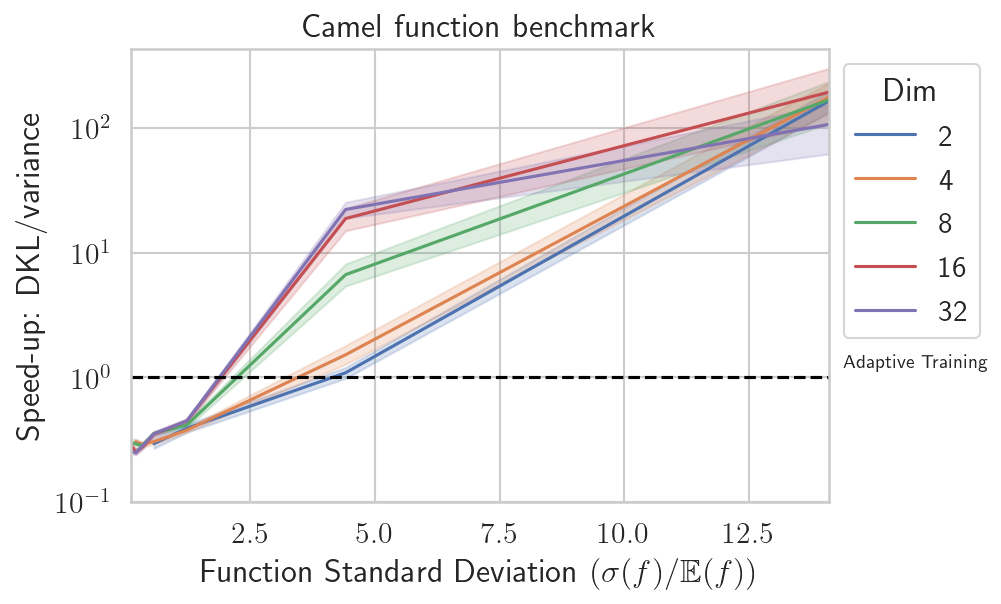

In [122]:
data_var = df.loc[df.loss=='variance'].loc[df.survey_strategy=='adaptive_variance']
data_dkl = df.loc[df.loss=='dkl'].loc[df.survey_strategy=='adaptive_dkl']

data = data_var.merge(data_dkl, on='s')
data = data.assign(
    flat_variance_ratio=data.flat_variance_ratio_y/data.flat_variance_ratio_x,
    relative_std = data.relative_std_x
)

data = data[[var_param, 'flat_variance_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_variance_ratio', hue='Dim')


ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log', ylim=[0.1, None], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Speed-up: DKL/variance')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.4,1.2,'Adaptive Training', fontsize='xx-small')
plt.show()

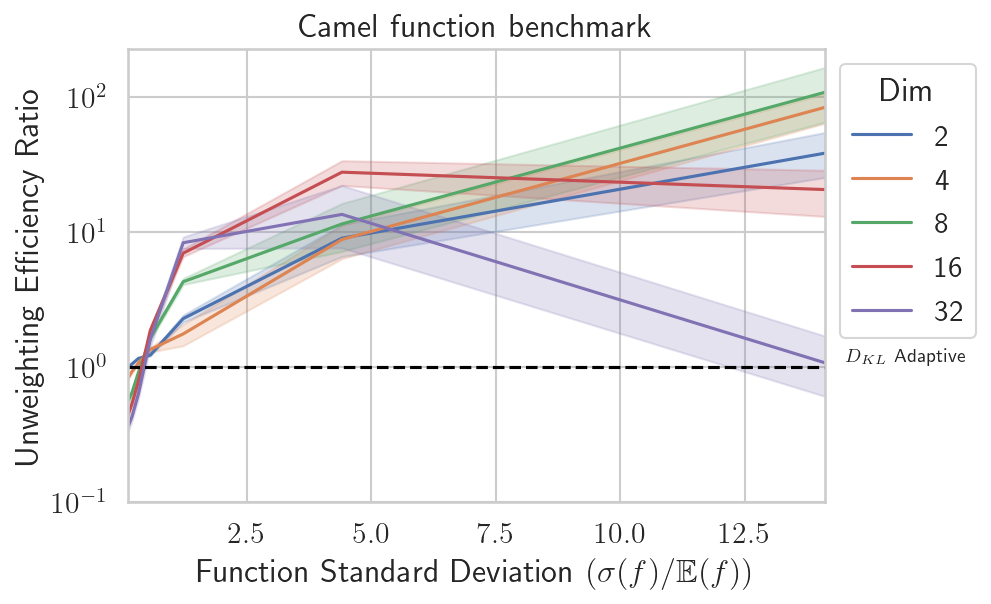

In [107]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'adaptive_dkl']
data = data[[var_param, 'flat_unweighting_eff_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_unweighting_eff_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, None], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Unweighting Efficiency Ratio')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,1.1e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

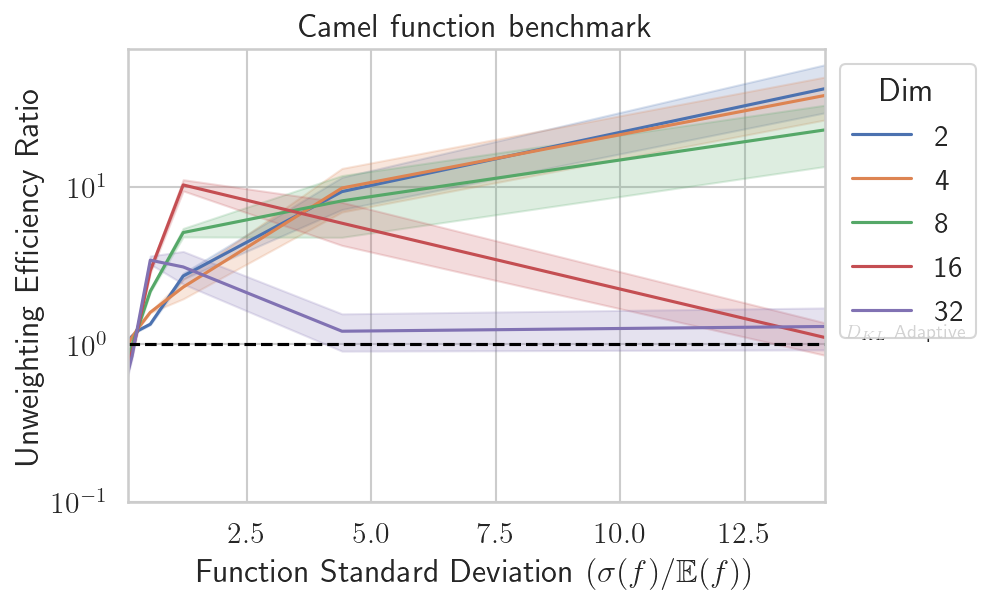

In [108]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'adaptive_variance']
data = data[[var_param, 'flat_unweighting_eff_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_unweighting_eff_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, None], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Unweighting Efficiency Ratio')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,1.1e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

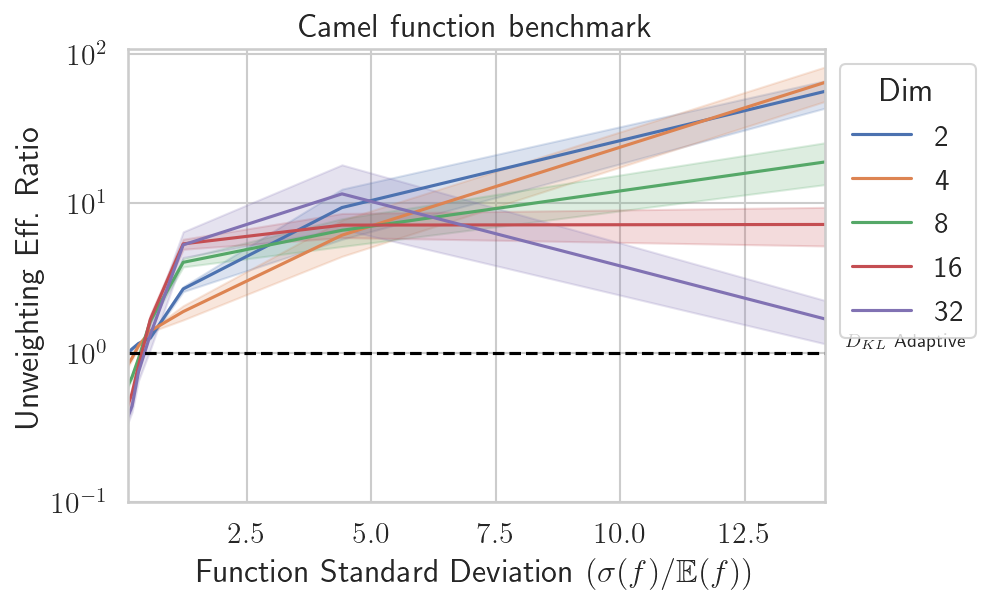

In [115]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'flat'].loc[df.loss=='dkl']
data = data[[var_param, 'flat_unweighting_eff_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_unweighting_eff_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, None], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Unweighting Eff. Ratio')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,1.1e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

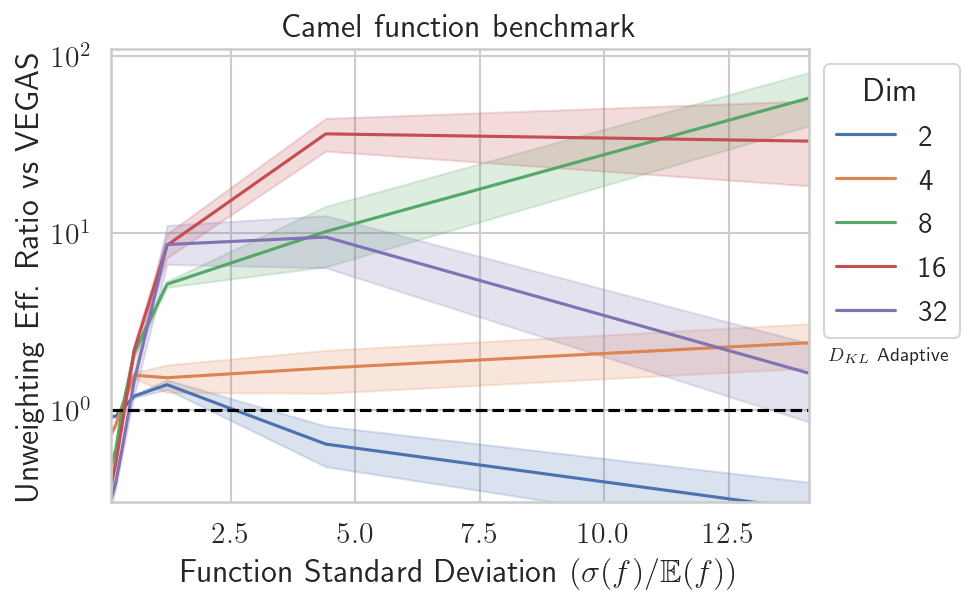

In [132]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'adaptive_dkl'].loc[df.loss=='dkl']
data = data[[var_param, 'vegas_unweighting_eff_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_unweighting_eff_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.3, None], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Unweighting Eff. Ratio vs VEGAS')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,1.9e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

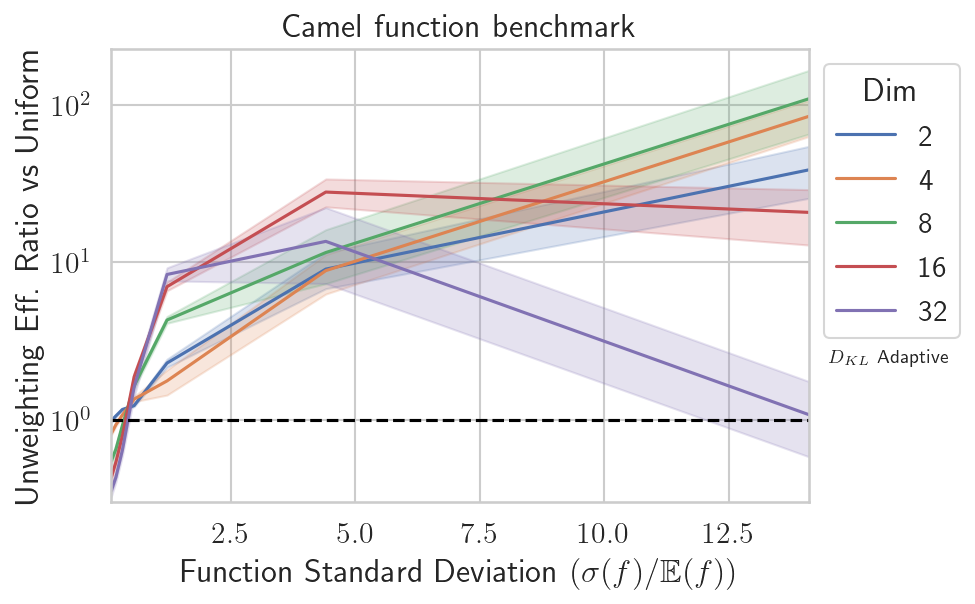

In [128]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'adaptive_dkl'].loc[df.loss=='dkl']
data = data[[var_param, 'flat_unweighting_eff_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='flat_unweighting_eff_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.3, None], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Unweighting Eff. Ratio vs Uniform')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,2.3e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

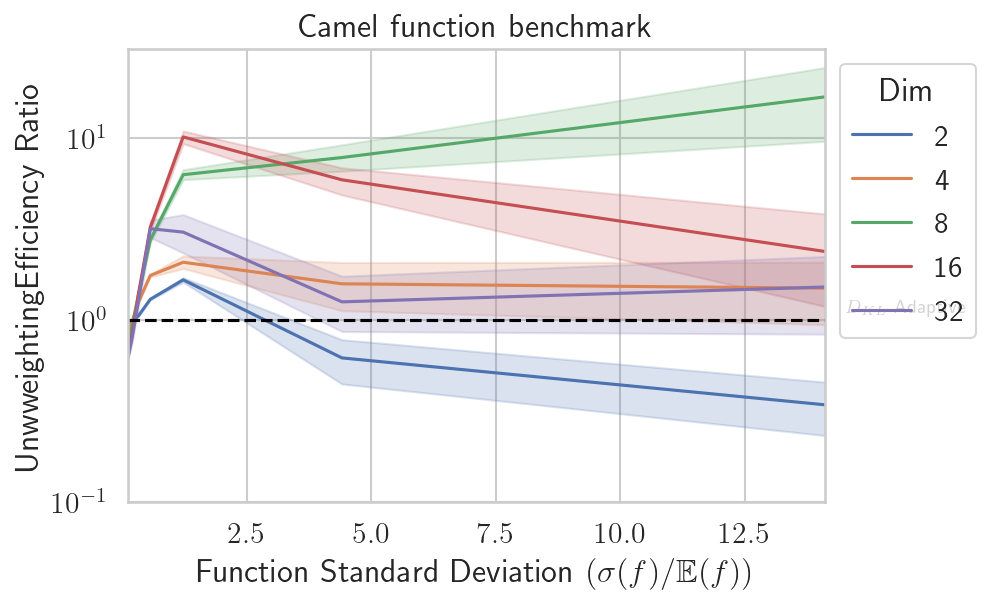

In [114]:
var_param = 'relative_std'
data = df.loc[df.survey_strategy == 'forward'].loc[df.loss=='variance']
data = data[[var_param, 'vegas_unweighting_eff_ratio']].assign(Dim=df['d'].astype(str))
ax = sns.lineplot(data=data,x=var_param,y='vegas_unweighting_eff_ratio', hue='Dim')
ax.plot([data[var_param].min(),data[var_param].max()], [1.,1.],c='black',ls='--')
ax.set(yscale='log',ylim=[0.1, None], xlim=[data[var_param].min(),data[var_param].max()])
ax.set(xlabel='Function Standard Deviation $(\sigma(f)/\mathbb{E}(f))$', ylabel='Unwweighting Efficiency Ratio')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dim')
ax.set_title('Camel function benchmark')
ax.text(14.5,1.1e0,'$D_{KL}$ Adaptive', fontsize='xx-small')
plt.show()

# Time measurements

In [17]:
df = df.assign(time_ratio = df.time_vegas / df.time_zunis).assign(Dim=df['d'].astype(str))

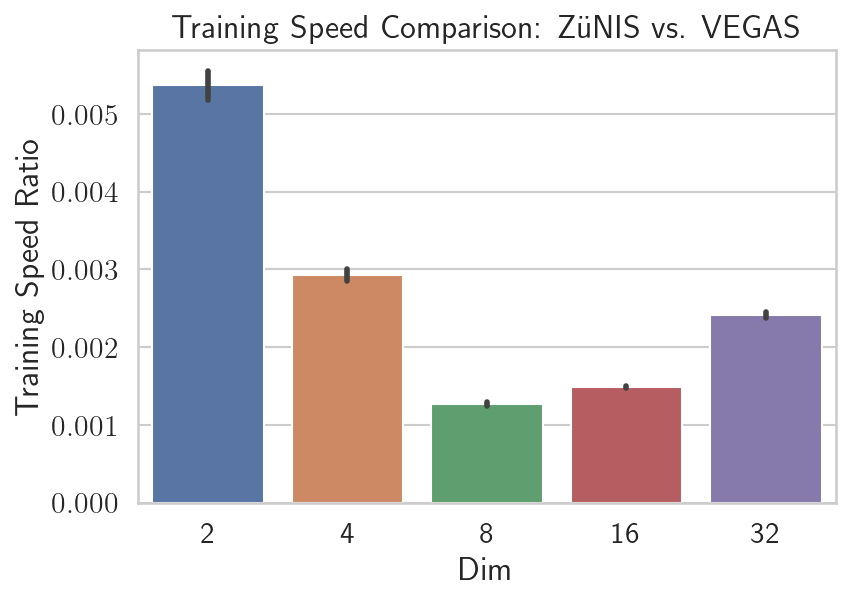

In [24]:
var_param = 'relative_std'
perf_param = 'time_ratio'
ax = sns.barplot(data = df, x='Dim', y=perf_param)
ax.set(xlabel='Dim', ylabel='Training Speed Ratio')
ax.set_title('Training Speed Comparison: ZüNIS vs. VEGAS')

plt.show()